# Time Series Analysis with Recurrent Nueral Networks (Keras)

IPython Notebook Source Link: https://www.youtube.com/watch?v=A7Lj_5AIkWQ

1. Get and Clean data
2. Prepare Data
3. Split into Training and Testing Data
4. Assemble Model
5. Train Model
6. Evaluate Model
7. Profit?

In [1]:
# prevent unnecessary display of IPython warnings
import warnings
warnings.filterwarnings('ignore')

# Import Tensorflow to use GPU when implementing Neural Networks
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
# display available devices for Tensorflow to use
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5321217825646509548
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8634068637347571353
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get and Clean Data

In [3]:
# import necessary libraries and functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

# Read in the historical data as a DataFrame
df = pd.read_csv('../Data Wrangling/AMZN.csv')
df = df.dropna(how='any')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5853,2020-08-18,3212.000000,3320.000000,3205.820068,3312.489990,3312.489990,5346000
5854,2020-08-19,3303.010010,3315.899902,3256.000000,3260.479980,3260.479980,4185100
5855,2020-08-20,3252.000000,3312.620117,3238.000000,3297.370117,3297.370117,3332500
5856,2020-08-21,3295.000000,3314.399902,3275.389893,3284.719971,3284.719971,3575900


## 2. Prepare Data

In [4]:
# Calculate Adj High and Adj Low by an adjustment factor 
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']

# Define new "data" DataFrame to for the next step below
data=df[['Adj Close','Adj High','Adj Low']]

# Define Daily and Weekly return and High-Low range to prepare for reframing
data['dailyReturn'] = np.log(data.loc[:,('Adj Close')]/data.loc[:,('Adj Close')].shift(1))
data['weeklyReturn'] = np.log(data.loc[:,'Adj Close']/data.loc[:,'Adj Close'].shift(5))
data['dailyHL'] = np.log(data.loc[:,'Adj High']/data['Adj Low'])
data['weeklyHL'] = np.log(data.loc[:,'Adj High'].rolling(6).max()/data.loc[:,'Adj Low'].rolling(6).min())

In [5]:
# Define toTimeSeries functions that creates trailing and leading columns based on a desired number of shifting periods.
# The resulting DataFrame will serve as observation data to be used by the RNN as training and testing data.
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [6]:
n_trail = 5 # Define number of trailing periods
n_lead = 5 # Define number of leading periods
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL'] # Define columns to be reframed

# Generate reframed data
reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.022141          -0.338602      0.098192       0.644357   
11          0.071974          -0.142175      0.131576       0.410742   
12          0.054067          -0.075986      0.120953       0.299516   
13         -0.033448          -0.065813      0.065813       0.287682   
14         -0.017153           0.053299      0.041385       0.226313   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.071974          -0.142175      0.131576       0.410742   
11          0.054067          -0.075986      0.120953       0.299516   
12         -0.033448          -0.065813      0.065813       0.287682   
13         -0.017153           0.053299      0.041385       0.226313   
14         -0.003466           0.071974      0.020907       0.226313   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10          0.054067          -0.075986  ...      0.06500

## 3. Split into Training and Testing Data

In [7]:
trainTestSplit = 0.75 # Define train-test split percentage

mask = np.random.rand(len(reframed.values)) < trainTestSplit

train = reframed.values[mask,:]
test = reframed.values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign input (X) and expected output (Y) training set
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

# Assign input (X) and expected output (Y) training set
X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

# Dimensions of training and test sets
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4357, 44)
(4357, 24)
(4357, 6, 4) (4357, 4) (1486, 6, 4) (1486, 16)
(4357, 6, 4) (4357, 4) (1486, 6, 4) (1486, 4)


## 4. Assemble the Model

In [8]:
# Import Keras (with Tensorflow already imported earlier as the backend) to assemble RNN layers
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Define desired simple RNN architecture to be used by an Nvidia GTX 1070 Ti GPU and compile
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0

In [9]:
# Confirm compiled RNN architecture with desired properties and parameters
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 5. Train the Model

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Train on 4357 samples, validate on 1486 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_3622 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_3926 in 

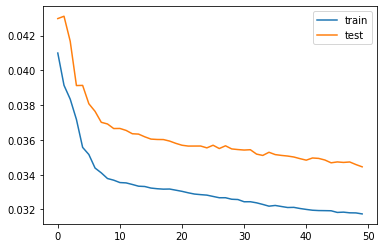

In [10]:
# fit simple RNN
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

# plot validation loss on training and test sets
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 6. Evaluate the Model

In [11]:
# Generate predictions from simple RNN model on input test data (X_test) and create 
# "results" DataFrame to store predictions and actuals (Y_test) for comparison
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 
                   'Predicted Weekly', 'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_20614 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,-0.063716,0.068053,0.003589,-0.007121,0.049479,0.123007
1,0.039740,0.039740,0.008052,0.010305,0.041213,0.126692
2,0.000000,-0.060219,-0.000375,-0.005844,0.050284,0.141563
3,0.034368,0.027399,0.005511,0.009783,0.025961,0.080519
4,-0.017036,0.003442,0.004870,0.007913,0.023883,0.076941


In [12]:
# Treat a signal's prediction as an upward (positive) or downward (negative) vector 
# and define accuracy scores based on two cases:
# i) direction and magnitude 
# ii) direction-only 

results['Correct'] = (results['Weekly Return']/results['Predicted Weekly']).apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.09488559892328398
Direction Only Accuracy Score:  0.5403768506056528


## 7. Profit?

In [13]:
# Calculate Risk-Reward column based on which weeks are "confidently" 
# considered as Buying and Selling weeks as a rough, simple backtest
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

# Define Buy/Sell thresholds
buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

# Calculate average annualized return over the entire investment period 
# with a starting investment of $1000 for both strategies
portfolio = [1000]
hodl = [1000]
bpFee = 20 # define portfolio management fees
feeModifier = 1 - (bpFee / 10000) # define fee modifier for portfolio calculations

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

# Decide the following for each prediction
for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal: # Calculate the result of a simulated long position 
                               # if a prediction is above the Buy threshold
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal: # Calculate the result of a simulated short position 
                               # if a prediction is below the Sell threshold
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1] # Do nothing if the prediction does not surpass either threshold
    
    # Append result to portfolio list
    portfolio.append(today)
    
    # Calculate change in account value and append result to hodl list
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  3.211033809044106 %


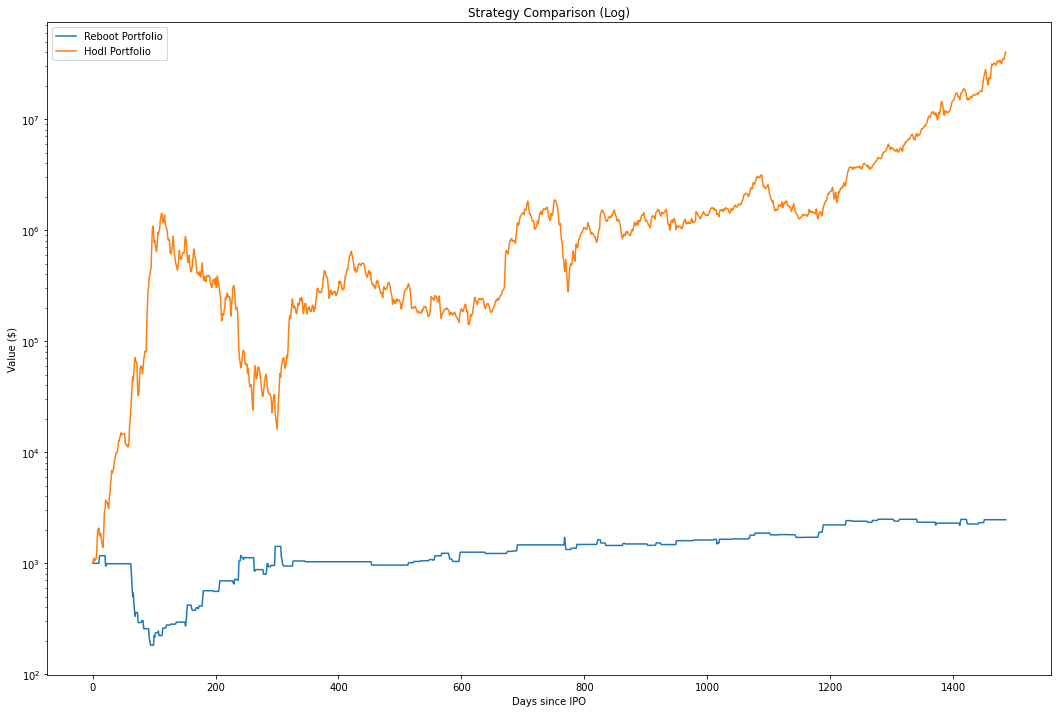

In [14]:
# Plot performance of both strategies over entire investment period for comparison along a LOG y-axis
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.xlabel('Days since IPO')
plt.ylabel('Value ($)')
plt.title('Strategy Comparison (Log)')
plt.yscale('log')
plt.show()

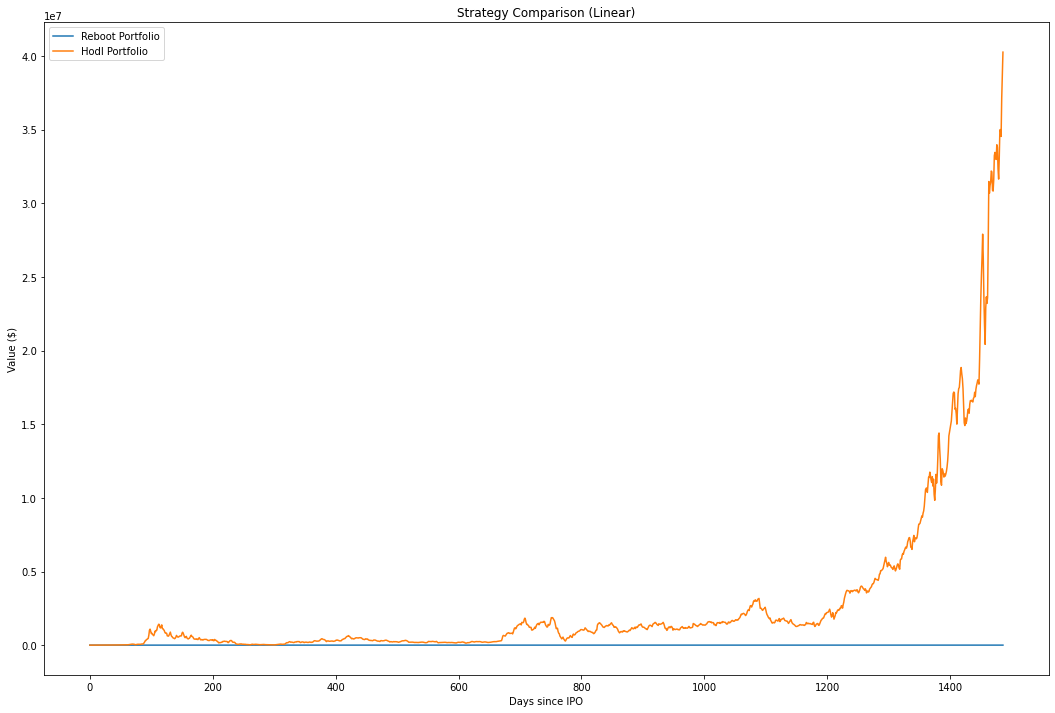

In [15]:
# Plot performance of both strategies over entire investment period for comparison along a LINEAR y-axis
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.xlabel('Days since IPO')
plt.ylabel('Value ($)')
plt.title('Strategy Comparison (Linear)')
plt.legend()
plt.show()

In [16]:
# Display results data to be used in Results Visuals notebook
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'AMZN'
port_df.head(10)

,portfolio,hodl,symbol
0,1000.0,1000.000000,AMZN
1,1000.0,1070.422069,AMZN
2,1000.0,1113.817549,AMZN
3,1000.0,1048.724329,AMZN
4,1000.0,1077.855793,AMZN
5,1000.0,1081.572299,AMZN
6,1000.0,1137.515681,AMZN
7,1000.0,1439.545138,AMZN
8,1000.0,1932.816282,AMZN
9,1000.0,2063.684373,AMZN
